In [1]:
from paretoCardinalityInfluence import *

import shutil
import matplotlib as mpl

# Enable LaTeX rendering if available (fallback to Matplotlib text otherwise)
if shutil.which("latex"):
    mpl.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}",
    })
else:
    mpl.rcParams.update({"text.usetex": False})

# Import influence datasets
data_path_HEPT = '../../datasets/raw_data/influence/NetHEPT/hep.txt'
data_path_PHY = '../../datasets/raw_data/influence/NetPHY/phy.txt'

G_HEPT = import_influence_data(data_path_HEPT)
G_PHY = import_influence_data(data_path_PHY)

2026-01-31 18:29:42,123 |INFO: Imported influence graph with 1673 nodes and 3863 edges
2026-01-31 18:29:43,413 |INFO: Imported influence graph with 912 nodes and 8748 edges


In [2]:
def findApproximateParetoSolutionsInfluence(G, k_max, num_samples=35, num_runs=10, dataset_name=""):
    '''
    Run algorithms over multiple runs and plot mean +/- std (Influence vs Cardinality).
    Parameters:
    - G: Graph
    - k_max: Maximum cardinality
    - num_samples: Number of Monte Carlo samples per run
    - num_runs: Number of independent runs
    - dataset_name: Name of the dataset for plotting
    '''
    algo_names = ["ParetoGreedy-Cardinality", "TopK", "Random"]

    # containers across runs
    all_influences = {alg: [] for alg in algo_names}
    all_runtimes = {alg: [] for alg in algo_names}

    for _ in range(num_runs):
        run_influences = {alg: [] for alg in algo_names}
        run_runtimes = {alg: [] for alg in algo_names}

        # Pareto Greedy (Cardinality)
        pareto = paretoCardinalityInfluence(G=G, k_max=k_max, num_samples=num_samples)
        _, _, runTime = pareto.paretoGreedy()
        influences = [pareto.kSolDict.get(k, {'Influence': 0})['Influence'] for k in range(1, k_max + 1)]
        run_influences['ParetoGreedy-Cardinality'] = influences
        run_runtimes['ParetoGreedy-Cardinality'] = runTime

        # Top K
        pareto2 = paretoCardinalityInfluence(G=G, k_max=k_max, num_samples=num_samples)
        _, _, runTime = pareto2.top_k()
        influences = [pareto2.kSolDict.get(k, {'Influence': 0})['Influence'] for k in range(1, k_max + 1)]
        run_influences['TopK'] = influences
        run_runtimes['TopK'] = runTime

        # Random
        pareto3 = paretoCardinalityInfluence(G=G, k_max=k_max, num_samples=num_samples)
        _, _, runTime = pareto3.random_selection()
        influences = [pareto3.kSolDict.get(k, {'Influence': 0})['Influence'] for k in range(1, k_max + 1)]
        run_influences['Random'] = influences
        run_runtimes['Random'] = runTime

        # store per-run arrays and total runtimes
        for alg in algo_names:
            arr = np.array(run_influences[alg], dtype=float)
            if arr.size == 0:
                arr = np.zeros(k_max, dtype=float)
            all_influences[alg].append(arr)
            all_runtimes[alg].append(run_runtimes[alg])

    # compute mean and std across runs for each algorithm
    mean_influences = {}
    std_influences = {}
    for alg in algo_names:
        stacked = np.vstack(all_influences[alg])  # shape (num_runs, k_max)
        mean_influences[alg] = np.mean(stacked, axis=0)
        std_influences[alg] = np.std(stacked, axis=0) * 0.5

    # Plot mean influence with shaded std band
    colors = plt.get_cmap("tab10").colors
    linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]
    markers = ['o', 's', '^', 'v', 'D']
    fig, ax = plt.subplots(figsize=(9, 5.5))
    for i, alg in enumerate(algo_names):
        mean = mean_influences[alg]
        std = std_influences[alg]
        is_pareto = alg in {"ParetoGreedy-Cardinality"}
        marker_size = 7 if is_pareto else 6
        line_style = '-' if is_pareto else ':'
        color = colors[i]
        marker = markers[i % len(markers)]
        zorder = 3
        if alg == "ParetoGreedy-Cardinality":
            color = colors[3]
            marker = "D"
            zorder = 4
        label = rf"\texttt{{{alg}}} (ours)" if is_pareto else rf"\texttt{{{alg}}}"
        ax.plot(range(1, k_max + 1), mean, label=label, color=color, linestyle=line_style, marker=marker, markersize=marker_size, markeredgewidth=1.1, markeredgecolor='k', linewidth=1.8, zorder=zorder)
        ax.fill_between(range(1, k_max + 1), np.clip(mean - std, 0, None), mean + std, color=color, alpha=0.18, zorder=2)
    
    ax.set_xlabel(r'Cardinality ($k$)', fontsize=28)
    ax.set_ylabel(r'Mean influence ($\bar{f}$)', fontsize=28)
    ax.set_title("")
    ax.grid(alpha=0.3)
    ax.tick_params(axis='both', labelsize=24)
    
    # Legend handles (saved separately)
    handles, labels = ax.get_legend_handles_labels()
    
    # Save figure
    from pathlib import Path
    base_dir = Path.cwd().resolve().parents[1]
    plots_dir = base_dir / "plots" / "cardinality"
    plots_dir.mkdir(parents=True, exist_ok=True)
    safe_name = (dataset_name or "dataset").replace(" ", "_")
    out_path = plots_dir / f"{safe_name}_cardinality.pdf"
    fig.savefig(out_path, bbox_inches="tight")
    
    # Save legend as separate PDF
    if handles:
        legend_out_path = plots_dir / "cardinality_legend.pdf"
        if not legend_out_path.exists():
            legend_fig = plt.figure(figsize=(8, 2))
            legend_fig.legend(handles, labels, loc='center', ncol=3, fontsize=22, frameon=True)
            legend_fig.savefig(legend_out_path, bbox_inches="tight")
            plt.close(legend_fig)
    
    plt.show()
    
    # Runtime summary (mean ± std)
    runtime_lines = ["Runtime summary (mean ± std, seconds):"]
    for alg in algo_names:
        mean_rt = float(np.mean(all_runtimes[alg])) if len(all_runtimes[alg]) > 0 else 0.0
        std_rt = float(np.std(all_runtimes[alg])) if len(all_runtimes[alg]) > 0 else 0.0
        runtime_lines.append(f"  - {alg}: {mean_rt:.3f} ± {std_rt:.3f}")
    logging.info("\n".join(runtime_lines))
    
    return None

### NetHEPT Experiments

2026-01-31 18:29:43,625 |INFO: Initialized Pareto Influence - Cardinality Cost Instance, Num Nodes:1673, k=75
2026-01-31 18:29:43,693 |INFO: Cardinality Greedy Solution for k_max:75, Influence:240.600, Runtime = 0.07 seconds
2026-01-31 18:29:43,857 |INFO: Initialized Pareto Influence - Cardinality Cost Instance, Num Nodes:1673, k=75
2026-01-31 18:29:43,894 |INFO: Top-k Solution for k_max:75, Influence:164.800, Runtime = 0.04 seconds
2026-01-31 18:29:44,056 |INFO: Initialized Pareto Influence - Cardinality Cost Instance, Num Nodes:1673, k=75
2026-01-31 18:29:44,061 |INFO: Random Selection Solution for k_max:75, Influence:96.300, Runtime = 0.00 seconds
2026-01-31 18:29:44,222 |INFO: Initialized Pareto Influence - Cardinality Cost Instance, Num Nodes:1673, k=75
2026-01-31 18:29:44,287 |INFO: Cardinality Greedy Solution for k_max:75, Influence:249.000, Runtime = 0.06 seconds
2026-01-31 18:29:44,491 |INFO: Initialized Pareto Influence - Cardinality Cost Instance, Num Nodes:1673, k=75
2026-0

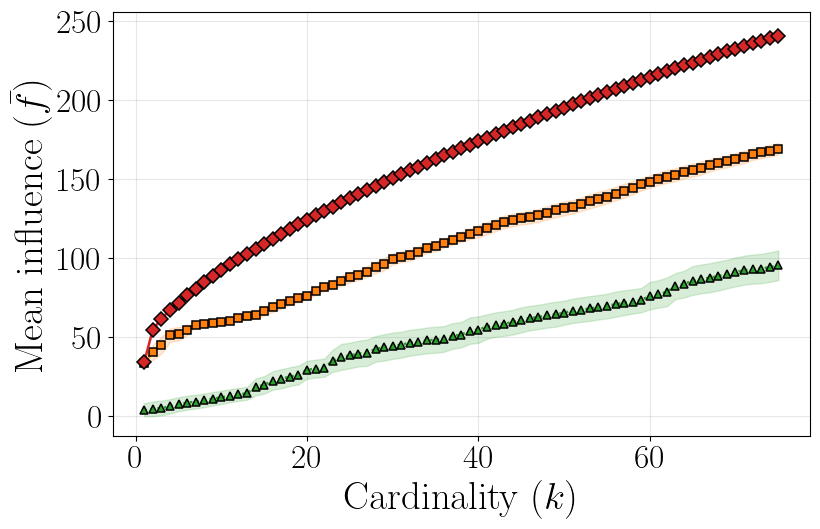

2026-01-31 18:29:50,625 |INFO: Runtime summary (mean ± std, seconds):
  - ParetoGreedy-Cardinality: 0.063 ± 0.004
  - TopK: 0.038 ± 0.001
  - Random: 0.005 ± 0.000


In [3]:
# Parameters
k_max = 75
num_samples = 10
num_runs = 10

findApproximateParetoSolutionsInfluence(G_HEPT, k_max, num_samples, num_runs, "NetHEPT")

### NetPHY Experiments

2026-01-31 18:29:50,990 |INFO: Initialized Pareto Influence - Cardinality Cost Instance, Num Nodes:912, k=75
2026-01-31 18:29:51,105 |INFO: Cardinality Greedy Solution for k_max:75, Influence:468.300, Runtime = 0.11 seconds
2026-01-31 18:29:51,448 |INFO: Initialized Pareto Influence - Cardinality Cost Instance, Num Nodes:912, k=75
2026-01-31 18:29:51,523 |INFO: Top-k Solution for k_max:75, Influence:365.700, Runtime = 0.07 seconds
2026-01-31 18:29:51,929 |INFO: Initialized Pareto Influence - Cardinality Cost Instance, Num Nodes:912, k=75
2026-01-31 18:29:51,948 |INFO: Random Selection Solution for k_max:75, Influence:376.500, Runtime = 0.02 seconds
2026-01-31 18:29:52,286 |INFO: Initialized Pareto Influence - Cardinality Cost Instance, Num Nodes:912, k=75
2026-01-31 18:29:52,395 |INFO: Cardinality Greedy Solution for k_max:75, Influence:468.200, Runtime = 0.11 seconds
2026-01-31 18:29:52,728 |INFO: Initialized Pareto Influence - Cardinality Cost Instance, Num Nodes:912, k=75
2026-01-31

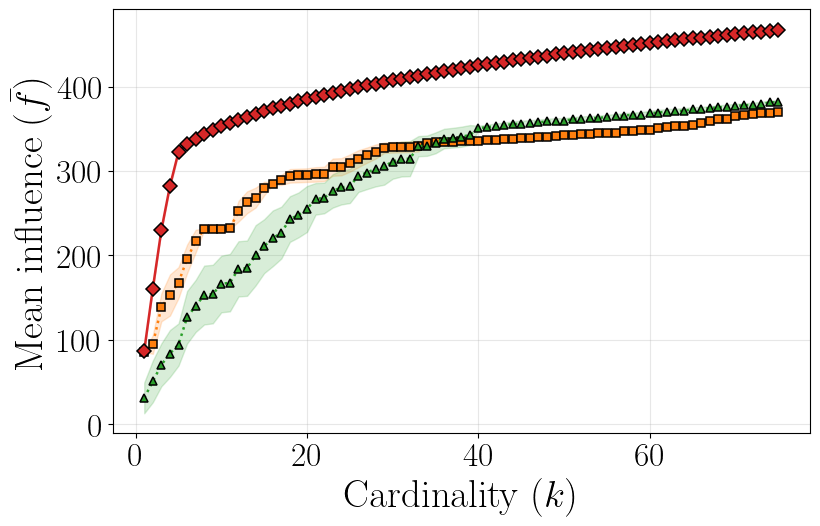

2026-01-31 18:30:03,428 |INFO: Runtime summary (mean ± std, seconds):
  - ParetoGreedy-Cardinality: 0.116 ± 0.007
  - TopK: 0.079 ± 0.003
  - Random: 0.017 ± 0.002


In [4]:
# Run for NetPHY
findApproximateParetoSolutionsInfluence(G_PHY, k_max, num_samples, num_runs, "NetPHY")